# Retrain a DCNN using Tensorflow-Hub

> Written by Dr Daniel Buscombe, Northern Arizona University

> Part of a series of notebooks for image recognition and classification using deep convolutional neural networks

This notebook is to demonstrate how to retrain a DCNN using transfer learning using tiles generated from labeled imagery (see 2.2. and 2.4)

## Transfer Learning

The most popular DCNN architectures have been designed and trained on large generic image libraries such as ImageNet, mostly developed as a result of international computer vision competitions and primarily for application to close-range imagery with small spatial footprints.

These applications have involved design and implementation of new or modified DCNN architectures, or relatively large existing DCNN architectures, and have largely been limited to satellite imagery. Though powerful, DCNNs are also computationally intensive to train and deploy, very data hungry (often requiring millions of examples to train from scratch), and require expert knowledge to design and optimize. 

We utilize a concept known as ‘transfer learning’, where a model trained on one task is re-purposed on a second related task. Fortunately, several open-source DCNN architectures have been designed for general applicability to the task of recognizing objects and features in non-specific photographic imagery. 

Here, we use existing pre-trained DCNN models that are designed to be transferable for generic image recognition tasks, which facilitates rapid DCNN training when developing classifiers for specific image sets. 

Training is rapid because only the final layers in the DCNN need to be retrained to classify a specific set of objects.

![](figs/dl_tools_retrain_tile.png)

In [6]:
import s3fs
fs = s3fs.S3FileSystem(anon=True)
root = 'esipfed/cdi-workshop'

Set TF_CPP_MIN_LOG_LEVEL to 1 to filter out INFO logs, 2 to additionall filter out WARNING, 3 to additionally filter out ERROR.

In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Define inputs

### Model

Which TensorFlow Hub module to use.

See https://github.com/tensorflow/hub/blob/r0.1/docs/modules/image.md

Among many suitable popular and open-source frameworks for image classification using deep convolutional neural networks, we chose MobileNetV2 because it is relatively small and efficient (computationally faster to train and execute) compared to many competing architectures designed to be transferable for generic image recognition tasks, such as Inception, Resnet, and NASnet, and it is smaller and more accurate than MobileNetV1. 

It also is pretrained for various tile sizes (image windows with horizontal and vertical dimensions of 96, 128, 192, and 224 pixels) which allows us to evaluate that effect on classifications. 

All of the aforementioned models are implemented within TensorFlow-Hub, which is a library specifically designed for reusing pre-trained TensorFlow models on new tasks. 

Like MobileNetV1, MobileNetV2 uses depthwise separable convolutions where, instead of doing a 2D convolution with a kernel, the same result is achieved by doing two 1D convolutions with two kernels, k1 and k2, where k = k1 · k2. This requires far fewer parameters, so the model is very small and efficient compared to a model with the same depth using 2D convolution. 

However, V2 introduces two new features to the architecture: 1) shortcut connections between the bottlenecks called inverted residual layers, and 2) linear bottlenecks between the layers. 

A bottleneck layer contains few nodes compared to the previous layers, used to obtain a representation of the input with reduced dimensionality, leading to large savings in computational cost. Residual layers connect the beginning and end of a convolutional layers with a skip connection, which gives the network access to earlier activations that weren’t modified in the convolutional layers, and make very deep networks without commensurate increases in parameters. Inverted residuals are a type of residual layer that has fewer parameters, which leads to greater computational efficiency. A ‘linear’ bottleneck is where the last convolution of a residual layer has a linear output before it is added to the initial activations. This preserves more information than the more-traditional non-linear bottlenecks, which leads to greater accuracy.

In [8]:
## TFHub module
tilesize = 224
module = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_'+str(tilesize)+'/classification/1'

## Retraining using Ontario tiles

Let's train on the tiles we just generated, from the Ontario dataset

In [9]:
direc = 'S3data_tile_'+str(tilesize)+'/'

Remember that the S3 is a read-only filesystem, so we need to copy those labels over

One way is to read those labels into an array, and then write them out to a file

In [10]:
with fs.open(root+'/semseg_data/ontario/labels/labels.txt', 'rb') as f:
      labels = f.readlines()

labels = [x.strip().decode() for x in labels]

In [11]:
labels

['anthro', 'sediment', 'terrain', 'veg', 'water']

If you want to write these out again to file again ...

In [12]:
with open('ontario_labels.txt', 'a') as the_file:
    for label in labels:
        the_file.write(label+'\n')

In [13]:
labels = 'ontario_labels.txt'

We cat use !cat to check the contents

In [14]:
!cat ontario_labels.txt

anthro
sediment
terrain
veg
water


### Bottlenecks

The first phase analyzes all the images on disk and calculates and caches the bottleneck values for each of them. 

'Bottleneck' is an informal term we often use for the layer just before the final output layer that actually does the classification. (TensorFlow Hub calls this an "image feature vector".) 

This penultimate layer has been trained to output a set of values that's good enough for the classifier to use to distinguish between all the classes it's been asked to recognize. That means it has to be a meaningful and compact summary of the images, since it has to contain enough information for the classifier to make a good choice in a very small set of values. The reason our final layer retraining can work on new classes is that it turns out the kind of information needed to distinguish between all the 1,000 classes in ImageNet is often also useful to distinguish between new kinds of objects.

Because every image is reused multiple times during training and calculating each bottleneck takes a significant amount of time, it speeds things up to cache these bottleneck values on disk so they don't have to be repeatedly recalculated. By default they're stored in the /tmp/bottleneck directory, and if you rerun the script they'll be reused so you don't have to wait for this part again.

In [15]:
### Path to cache bottleneck layer values as files
bn_dir = './bottleneck'

In [16]:
## Where to save summary logs for TensorBoard.
sumdir = './summaries'

### Training

Once the bottlenecks are complete, the actual training of the top layer of the network begins. You'll see a series of step outputs, each one showing training accuracy, validation accuracy, and the cross entropy. The training accuracy shows what percent of the images used in the current training batch were labeled with the correct class. The validation accuracy is the precision on a randomly-selected group of images from a different set. The key difference is that the training accuracy is based on images that the network has been able to learn from so the network can overfit to the noise in the training data. A true measure of the performance of the network is to measure its performance on a data set not contained in the training data -- this is measured by the validation accuracy. If the train accuracy is high but the validation accuracy remains low, that means the network is overfitting and memorizing particular features in the training images that aren't helpful more generally. Cross entropy is a loss function which gives a glimpse into how well the learning process is progressing. The training's objective is to make the loss as small as possible, so you can tell if the learning is working by keeping an eye on whether the loss keeps trending downwards, ignoring the short-term noise.

By default this script will run 4,000 training steps. Each step chooses ten images at random from the training set, finds their bottlenecks from the cache, and feeds them into the final layer to get predictions. Those predictions are then compared against the actual labels to update the final layer's weights through the back-propagation process. As the process continues you should see the reported accuracy improve, and after all the steps are done, a final test accuracy evaluation is run on a set of images kept separate from the training and validation pictures. This test evaluation is the best estimate of how the trained model will perform on the classification task. You should see an accuracy value of between 90% and 95%, though the exact value will vary from run to run since there's randomness in the training process. This number is based on the percent of the images in the test set that are given the correct label after the model is fully trained.

### Learning rate

This parameter tells the optimizer how far to move the weights in the direction of the gradient for a mini-batch.

If the learning rate is low, then training is more reliable, but optimization will take a lot of time because steps towards the minimum of the loss function are tiny.

If the learning rate is high, then training may not converge or even diverge. Weight changes can be so big that the optimizer overshoots the minimum and makes the loss worse.

The training should start from a relatively large learning rate because, in the beginning, random weights are far from optimal, and then the learning rate can decrease during training to allow more fine-grained weight updates.

In [17]:
num_steps = 1000
learnrate = 0.01

graph = 'ontario_test_mobilenetv2_'+str(tilesize)+'_'+str(num_steps)+'_'+str(learnrate)+'.pb'

Model retraining (sometimes called ‘fine-tuning’) consists of tuning the parameters in just the final layer rather than all the weights within all of the network’s layers. Model retraining consists of first using the model, up to the final classifying layer, to generate mage feature vectors for each input tile, 

Then retraining only the final, so-called fully connected, model layer that actually does the classification. 

For each training epoch, feature vectors from tiles are chosen at random from the training set, and feeds them into the final layer to get predict the class. 

Those class predictions are then compared against the actual labels, which is used to update the final layer's weights through back-propagation. 

Tensorflow produces a LOT of output which we want to suppress, so we use the %%capture magic command

This will take a few minutes to run. Let's watch a video on 'classic' network architectures

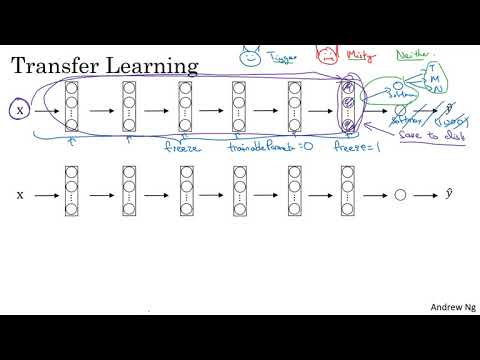

In [18]:
from IPython.display import YouTubeVideo
##transfer learning
YouTubeVideo('FQM13HkEfBk') ##9 mins

In [19]:
##!touch tile_224/.ipynb_checkpoints/

Now we run the training script (approx. 12 mins)

In [20]:
%%capture
%run ./retrain.py --image_dir $direc --tfhub_module $module --how_many_training_steps $num_steps \
                  --bottleneck_dir $bn_dir --summaries_dir $sumdir \
                  --learning_rate $learnrate --output_labels $labels --output_graph $graph

AttributeError: 'NoneType' object has no attribute 'keys'

## Retraining using the CCR tiles

We use exactly the same procedure for the CCR tiles

In [21]:
tilesize = 224
num_steps = 1000
learnrate = 0.01
graph = 'ccr_test_mobilenetv2_'+str(tilesize)+'_'+str(num_steps)+'_'+str(learnrate)+'.pb'
bn_dir = './ccr_bottleneck'
sumdir = './ccr_summaries'
direc = 'ccr_train/tile_224'

In [22]:
with fs.open(root+'/semseg_data/ccr/labels/labels.txt', 'rb') as f:
      labels = f.readlines()

labels = [x.strip().decode() for x in labels]

with open('ccr_labels.txt', 'a') as the_file:
    for label in labels:
        the_file.write(label+'\n')     

In [23]:
labels = 'ccr_labels.txt'   

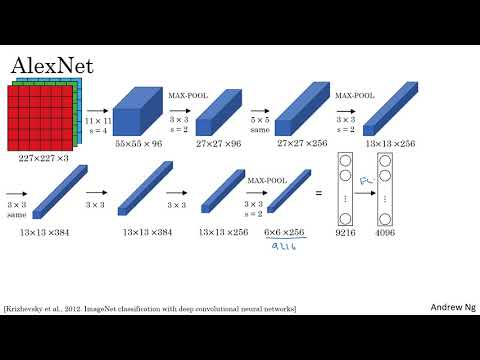

In [24]:
##classic network architectures
YouTubeVideo('dZVkygnKh1M') ##18 mins

In [25]:
## 20 mins

In [26]:
%%capture
%run ./retrain.py --image_dir $direc --tfhub_module $module --how_many_training_steps $num_steps \
                  --bottleneck_dir $bn_dir --summaries_dir $sumdir \
                  --learning_rate $learnrate --output_labels $labels --output_graph $graph

AttributeError: 'NoneType' object has no attribute 'keys'

Unfortunately, doing it that way means we don't get to see any of the outputs. Alternatively, we can do it with bash like this

(note this will run faster this time becuse we already created the bottlenecks)

In [27]:
## 1 min

In [28]:
%%bash -s "$direc" "$module" "$num_steps" "$bn_dir" "$sumdir" "$learnrate" "$labels" "$graph"
python retrain.py --image_dir $1 --tfhub_module $2 --how_many_training_steps $3 --bottleneck_dir $4 --summaries_dir $5 --learning_rate $6 --output_labels $7 --output_graph $8 &> output.txt

Then we can use another bash command to query the file for the final accuracy (buried in hundreds or thousands or lines of output)

In [29]:
!grep "Final test accuracy" output.txt

In [30]:
!rm output.txt

### Fine-tuning

Optimizing hyperparameters

* learning rate
* train batch size
    * How many images to train on at a time
* test batch size
    * How many images to test on. This test set is only used once, to evaluate
      the final accuracy of the model after training completes.
      A value of -1 causes the entire test set to be used, which leads to more
      stable results across runs.
* validation batch size
    *  How many images to use in an evaluation batch. This validation set is
      used much more often than the test set, and is an early indicator of how
      accurate the model is during training.
      A value of -1 causes the entire validation set to be used, which leads to
      more stable results across training iterations, but may be slower on large
      training sets.
* validation percentage
    * What percentage of images to use as a validation set

In [31]:
valid_batch = 200 ##default = 100
valid_prc = 20 ##default=10
train_batch = 200 ##default = 100
test_prc = 20 ##deafult = 10

Set the learning rate and number of training epochs

In [32]:
learnrate = 0.01 ##default = 0.01
num_steps = 1000 ##default=4000

Define new graph ("ft" for "fine-tuned")

In [33]:
graph = 'ccr_mobilenetv2_'+str(tilesize)+'_'+str(num_steps)+'_'+str(learnrate)+'_ft.pb'

Now we can run the script again

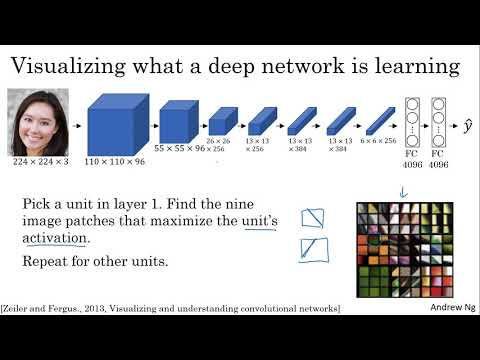

In [34]:
##classic network architectures
YouTubeVideo('ChoV5h7tw5A') ##8 mins

In [35]:
### 2 mins

In [36]:
%%capture
%run ./retrain.py --image_dir $direc --tfhub_module $module --how_many_training_steps $num_steps \
                  --testing_percentage $test_prc --train_batch_size $train_batch \
                  --validation_batch_size $valid_batch --validation_percentage $valid_prc \
                  --learning_rate $learnrate --bottleneck_dir $bn_dir --summaries_dir $sumdir \
                  --output_labels $labels --output_graph $graph

AttributeError: 'NoneType' object has no attribute 'keys'

or ... (note that when you get to 10 or more input parameters, you need to wrap them in curly brackets, like below)

In [37]:
%%bash -s "$direc" "$module" "$num_steps" "$bn_dir" "$sumdir" "$learnrate" "$labels" "$graph" "$valid_batch" "$valid_prc" "$test_prc" "$train_batch"
python retrain.py --image_dir $1 --tfhub_module $2 --how_many_training_steps $3 --bottleneck_dir $4 --summaries_dir $5 \
       --learning_rate $6 --output_labels $7 --output_graph $8 --validation_batch_size $9 --validation_percentage ${10} \
       --testing_percentage ${11} --train_batch_size ${12} &> output.txt

In [38]:
!grep "Final test accuracy" output.txt
!rm output.txt

How did it compare?

## Tidying up

The workspace we have is limited so its best to tidy up as we go

In [39]:
!rm -rf summaries
!rm -rf ccr_summaries
!rm -rf bottleneck
!rm -rf ccr_bottleneck
!rm -rf S3data_tile_224
!rm -rf ccr_train/tile_224

In [40]:
## uncomment this if you want to remove these files (we will be using them in the next lesson so not recommended)
#!rm ontario_labels.txt
#!rm ccr_labels.txt
#!rm ccr_mobilenetv2_224_1000_0.01_ft.pb
#!rm ccr_test_mobilenetv2_224_1000_0.01.pb
#!rm ontario_test_mobilenetv2_224_1000_0.01.pb

### Data augmentation

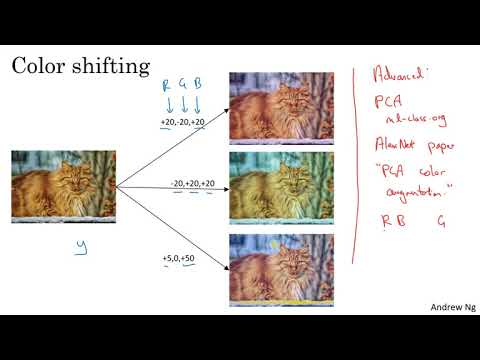

In [41]:
##data augmentation
YouTubeVideo('JI8saFjK84o') ##9 mins

A common way of improving the results of image training is by deforming, cropping, or brightening the training inputs in random ways.

This has the advantage of expanding the effective size of the training data thanks to all the possible variations of the same images, and tends to help the network learn to cope with all the distortions that will occur in real-life uses of the classifier. 

The biggest disadvantage of enabling these distortions in our script is that the bottleneck caching is no longer useful, since input images are never reused exactly. 

This means the training process takes a lot longer (many hours), so it's recommended you try this as a way of polishing your model only after you have one that you're reasonably happy with.

* Random brightness
    * A percentage determining how much to randomly multiply the training image
      input pixels up or down by.
* Random scale
    * A percentage determining how much to randomly scale up the size of the
      training images by.
* Random crop
    * A percentage determining how much of a margin to randomly crop off the
      training images.
* Flipping
    * Whether to randomly flip half of the training images horizontally.

In [42]:
#random crop
rc = 10

#random scale
rs = 10

##random brightness
rb = 10

Define new graph ("da" stands for "data augmented")

In [43]:
graph = 'ccr_mobilenetv2_'+str(tilesize)+'_'+str(num_steps)+'_'+str(learnrate)+'_ft_da.pb'

We're going to severe reduce the number of training steps for time efficiency

In [44]:
num_steps = 100

THIS CODE IS ILLUSTRATIVE ONLY. DON'T EXECUTE THIS CODE IN CLASS - IT TAKES A VERY LONG TIME

In [45]:
%%capture
%run ./retrain.py --image_dir $direc --tfhub_module $module --how_many_training_steps $num_steps \
                  --testing_percentage $test_prc \
                  --validation_batch_size $valid_batch --validation_percentage $valid_prc \
                  --learning_rate $learnrate --bottleneck_dir $bn_dir --summaries_dir $sumdir \
                  --flip_left_right True --random_crop $rc --random_scale $rs --random_brightness $rb \
                  --output_labels $labels --output_graph $graph

AttributeError: 'NoneType' object has no attribute 'keys'

## Other models

### MobileNetV2, 96 pixel tile

In [46]:
module = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/classification/1'
tilesize = 96
direc = 'ccr_train/tile_'+str(tilesize)+'/'
graph = 'ccr_mobilenetv2_'+str(tilesize)+'_'+str(num_steps)+'_'+str(learnrate)+'.pb'

In [47]:
imdirec='ccr_train'
threshold = 0.9
prop_keep=0.25
%run ./retile.py -i $imdirec -t $tilesize -a $threshold -b $prop_keep

ValueError: too many values to unpack (expected 5)

Run the script

In [48]:
%%capture 
%run ./retrain.py --image_dir $direc --tfhub_module $module --how_many_training_steps $num_steps \
                  --learning_rate $learnrate --bottleneck_dir $bn_dir --summaries_dir $sum_dir \
                  --output_labels $labels --output_graph $graph

SystemExit: 2

### Inception V3

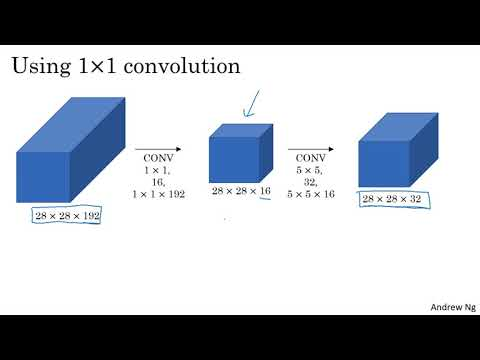

In [49]:
##Inception
YouTubeVideo('C86ZXvgpejM') ## 10 mins

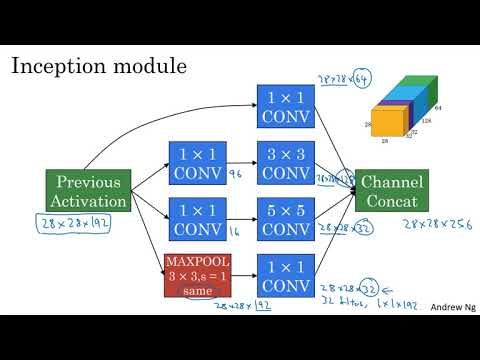

In [50]:
YouTubeVideo('KfV8CJh7hE0') ##8 mins

In [51]:
module = 'https://tfhub.dev/google/imagenet/inception_v3/classification/1'
##tilesize = 299

import tensorflow_hub as tfhub
m = tfhub.Module(module)
tilesize, _ = tfhub.get_expected_image_size(m)
print("tilesize = %i " % tilesize)

direc = 'train/tile_'+str(tilesize)+'/'
graph = 'ccr_inceptionv3_'+str(tilesize)+'_'+str(num_steps)+'_'+str(learnrate)+'.pb'

tilesize = 299 


In [52]:
imdirec='train'
threshold = 0.9
prop_keep=0.25
%run ./retile.py -i $imdirec -t $tilesize -a $threshold -b $prop_keep

ValueError: too many values to unpack (expected 5)

Run the script

In [53]:
%%capture
%run ./retrain.py --image_dir $direc --tfhub_module $module --how_many_training_steps $num_steps \
                  --learning_rate $learnrate --bottleneck_dir $bn_dir --summaries_dir $sum_dir \
                  --output_labels $labels --output_graph $graph

SystemExit: 2

### Inception-Resnet V2

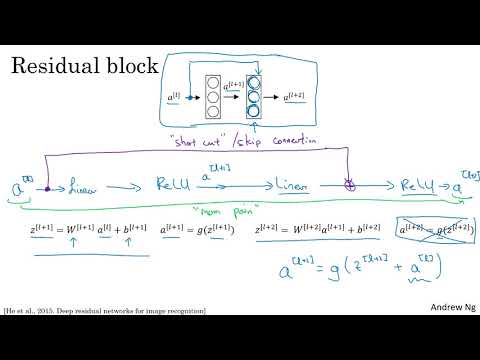

In [54]:
##Resnet
YouTubeVideo('ZILIbUvp5lk') ## 7 mins

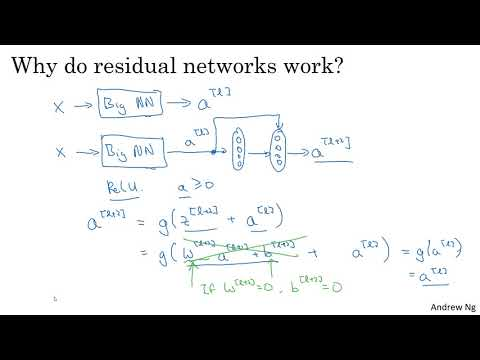

In [55]:
YouTubeVideo('RYth6EbBUqM') ##9 mins

In [56]:
module = 'https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/1'

m = tfhub.Module(module)
tilesize, _ = tfhub.get_expected_image_size(m)
print("tilesize = %i " % tilesize)

direc = 'ccr_train/tile_'+str(tilesize)+'/'
graph = 'ccr_irv2_'+str(tilesize)+'_'+str(num_steps)+'_'+str(learnrate)+'.pb'

tilesize = 299 


Run the script

In [57]:
%%capture
%run ./retrain.py --image_dir $direc --tfhub_module $module --how_many_training_steps $num_steps \
                  --learning_rate $learnrate --bottleneck_dir $bn_dir --summaries_dir $sum_dir \
                  --output_labels $labels --output_graph $graph

SystemExit: 2

## DL-tools

The equivalent function in DL-tools is called and is the same as used here, i.e.

```python train_dcnn_tfhub\retrain.py --image_dir --tfhub_module --how_many_training_steps --learning_rate --bottleneck_dir --summaries_dir --output_labels --output_graph```

Note that if you're outside the conda environment and want to call this script from within a bash script, examples are provided